# PlGreen Maskell 2017
implementing the third algorithm second is just a simplificaiton of the first that uses less memory so may be useful for barkla but is kind of trivial at the smae time

* this extension uses smc for the resampling alg as well, by the sounds of it
* still on static param estimaiton

In [ ]:
%%capture output
%pip install numpy
%pip install matplotlib

sample count limited to 1 per new observation: 499


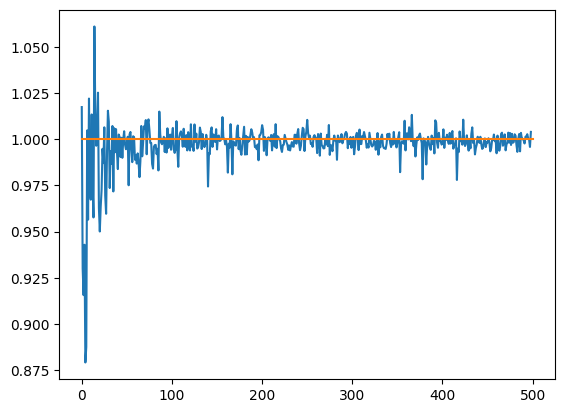

In [7]:
import numpy as np
import matplotlib.pyplot as plt

beta_0 = 1
beta_e = 100
mu_0 = 0

def normal_dist(x,mu,var):
    sigma = var**(1/2)
    return (1/(sigma*(np.pi*2)**(1/2)))*np.e**(-0.5*((x-mu)/sigma)**2)

def yt_func(x_t:float,theta) -> float:
    """give the value of theta we want to check against the
    observaiton"""
    return theta*x_t

def zt_func(x_t:float) -> float:
    actual_theta = 1 # given becuase we are making observations
    # of the real system
    error = np.random.randn(1)[0]*(1/beta_e)
    return yt_func(x_t,actual_theta)+error

def prob_z_given_theta(z_1_to_t, x_1_to_t,theta):
    """
    take arr z,x and scalar theta
    """
    k = 1
    sig_sum = 0
    for zt, xt in zip(z_1_to_t,x_1_to_t):
        sig_sum += (zt-yt_func(xt,theta))**2
    return k*np.e**((-beta_e/2)*sig_sum)

def prob_theta(theta):
    return np.e**((-beta_0/2)*(theta-mu_0)**2)

def beta_func(x_1_to_t):
    sig_sum = 0
    for xt in x_1_to_t:
        sig_sum += xt**2
    return beta_e*sig_sum+beta_0

def mu_func(z_1_to_t,x_1_to_t):
    sig_sum = 0
    for zt, xt in zip(z_1_to_t,x_1_to_t):
        sig_sum += xt*zt
    beta = beta_func(x_1_to_t)
    return (1/beta)*(beta_e*sig_sum+beta_0*mu_0)

def prob_theta_given_z(theta,z_1_to_t,x_1_to_t):
    return np.e**((-beta_func(x_1_to_t)/2)*theta-mu_func(z_1_to_t,x_1_to_t))

# just some wrapper functions might help my understanding
def liklihood(z_1_to_t,x_1_to_t, theta_arr):
    return [prob_z_given_theta(z_1_to_t,x_1_to_t,theta) for theta in theta_arr]

def prior(theta):
    return prob_theta(theta)

# im really not sure about this function
# this being wrong does also make my l kernel wrong
def prior_conditional(theta_hat,theta):
    return normal_dist(theta_hat,theta,0.1)

# since we are using gaussian proposal dist we acc don't need this
# since this and the term above return identical p so cancel
def l_kernel(theta, theta_hat):
    return  normal_dist(theta,theta_hat,0.1)

def get_inital_samples(n):
    theta_arr = [mu_0]*n
    return theta_arr+(np.random.randn(n)*beta_0)

# idk is this is the correct word as techincally
# this is the prior once the new timestep is reached
# and we want to get the next posterior 
# which again becomes the new prior? idek
def defensive_sampling(theta_arr):
    probs = np.random.rand(len(theta_arr))
    random_step = np.random.randn(len(theta_arr))
    theta_hat = []
    for th, p, r in zip(theta_arr,probs, random_step):
        if p<=0.9:
            theta_hat.append(th+r*0.1)
        else:
            theta_hat.append(th+r)
    return np.array(theta_hat)     

def posterior(z_1_to_t,x_1_to_t):
    return prob_theta_given_z(z_1_to_t,x_1_to_t)

def norm_weights(weights):
    return weights/sum(weights)

def reset_weights(n):
    return np.array([1]*n)

# this should just take zt the whole liklihood thing is probs 
# wrong
def new_weights(weights,z_arr,x_arr,theta,theta_hat):
    w_hat = []
    for w,th,th_hat in zip(weights,theta,theta_hat):
        temp1 = prob_z_given_theta(z_arr,x_arr,th_hat)
        temp2 = prob_z_given_theta(z_arr,x_arr,th)
        temp3 = temp1/temp2
        #print(f't1:{temp1}:t2:{temp2}:t3:{temp3}')
        # just getting rid of infs and nans so 0 val for all of 
        # them shouldn't matter after i normalise although
        # probably affects the efficiency
        # technically temp2 will always be one given the l kernel we chose
        # so just setting temp2 = 1
        temp4 = l_kernel(th, th_hat)/prior_conditional(th_hat,th)
        w_hat.append(w*temp3*temp4)
    return w_hat

def get_neff(weights):
    squared_sum = 0
    for w in weights:
        squared_sum += w*w
    return 1/squared_sum

#importance sampling
def resample(curr_theta, weights):
    new_theta = []
    new_theta = np.random.choice(curr_theta,size = len(curr_theta), p=weights)
    return np.array(new_theta)


def prob_z_scalar_given_theta(zt, xt,theta):
    """
    take scalar z,x and scalar theta
    """
    k = 1
    sig_sum = (zt-yt_func(xt,theta))**2
    return k*np.e**((-beta_e/2)*sig_sum)

def new_weights_different(weights, z,x,theta_arr):
    new_weights = []
    for th,w in zip(theta_arr,weights):
        new_weights.append(w*prob_z_scalar_given_theta(z,x,th))
    return new_weights

total_t = 500
# remember the observations happen sequentially
xt_arr = []
xt_arr.append(np.random.rand(1)[0])
# grab all of yt bear in mind i shouldn't know this it will
# only be needed for plotting later
# yt_arr = np.array([yt_func(x) for x in xt_arr])

zt_arr = []
n = 100

sample_count= 0

theta = get_inital_samples(n=n)
zt_arr.append(zt_func(xt_arr[-1]))
weights = liklihood(zt_arr,xt_arr,theta)
estimates = []

time = 1
while time<total_t:
    # new system change
    xt_arr.append(np.random.rand(1)[0])
    # new observation is then made
    zt_arr.append(zt_func(xt_arr[-1]))
    weights = norm_weights(weights)
    neff = get_neff(weights)
    while (neff<n/2):
        sample_count += 1
        theta = resample(theta,weights)
        weights = reset_weights(n)
        theta_hat = defensive_sampling(theta)
        weights = new_weights(weights,zt_arr,xt_arr,theta,theta_hat)
        theta = theta_hat
        weights = norm_weights(weights)
        neff = get_neff(weights)
        # temp break so it doesn't get stuck in a loop just
        break
    time+=1
    weights = new_weights_different(weights,zt_arr[-1],xt_arr[1],theta)
    # save what the estimate was at this time
    estimates.append(np.linalg.matmul(norm_weights(weights),theta))

# the while neff trap is fixable if we lower the covar on the 
# defense sampling step, but there are still way too many resampling
# evens maybe somehting else is also wrong like the magnitude of 
# noise that is in either z or y idk

print(f'sample count limited to 1 per new observation: {sample_count}')

# not using ck or anything to use weights, theta, and neff from 
# previous step, to get a lower variance estimate

plt.plot(estimates)
plt.plot([0,total_t],[1,1])
plt.show()

# Problems

* ok so the reason it doesn't work is because its getting stuck in
a resampling loop, idk how though - my best guess is that the 
weight calc is somehow off bc if you only take through ur good 
samples in the resampling event at the top of the loop
then it shouldn't get stuck in a loop

* If i Break the loop so that it doesn't get stuck the code still
produces a really good estimate for theta, i still think the new weights function is wrong though


* im like 99% sure this might be an inf issue since that seems very common in a lot of pl greens code, were he has to check for infs and remove them see lines 180 ish of this link: https://github.com/plgreenLIRU/SMC_approx_optL/blob/master/SMC_BASE.py

In [9]:
print(weights[:10])
theta_pred = np.linalg.matmul(norm_weights(weights),theta)

print(f'this should be close to one it is: {theta_pred}')

[np.float64(3.341474847956993e-43), np.float64(5.08412091154216e-25), np.float64(8.528657539437387e-31), np.float64(4.776895658304267e-25), np.float64(1.7779816031324526e-17), np.float64(4.593915422678593e-39), np.float64(4.434162210115577e-56), np.float64(2.2983507387515e-64), np.float64(0.0), np.float64(1.439402772284823e-18)]
this should be close to one it is: 1.0030912609534381


# new weights

so theta describes the dynamics of the system it just so happens that this system is just linear, so theta is 1d and should be found to equal one, so when we change theta we check it against all previous observations because the funciton/equation isn't dependant on time?